In [105]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [106]:
import pandas as pd
import utils
import utils

TS = 48

samples = list(range(201, 211)) #[201, 202, 203]
data_train, df_date = utils.load_data(samples, TS)


(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)


State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [107]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        HDS = 128
        self.layer1 = nn.Linear(n_observations, HDS)
        self.layer2 = nn.Linear(HDS, HDS)
        self.layer3 = nn.Linear(HDS, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [108]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_observaons = 7
print(n_observaons)
n_actions = 2
policy_net = DQN(n_observaons, n_actions).to(device)
target_net = DQN(n_observaons, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

7


<All keys matched successfully>

In [109]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 0.01
    
    # return policy_net(state).max(1).indices.view(1, 1)

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [110]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

In [111]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [112]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

    return loss.item()

    

In [ ]:
def Action(x):
    if x.item() == 1:
        return "Charge"
    elif x.item() == 0:
        return "Discharge"
    else:
        return "None"
    
loss_list = []
reward_list = []
num_episodes = len(data_train)

for i_episode in range(num_episodes):
    epMemory = list()

    env = utils.ENV_BATT(data_train[i_episode%len(data_train)])
    state = env.reset()    
    state = torch.tensor(state).unsqueeze(0)

    loss_value = 0.0
    reward_value = 0.0
        
    for i in range(env.data_env.shape[0]):
        action = select_action(state)        
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        reward_value += reward.squeeze(0).numpy()

        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        # print(t, ' Action : ', action, 's : ', state, 'ns : ', next_state, 'reward :', round(reward.item(), 2))
        
        memory.push(torch.as_tensor(state), action, next_state, reward)
        state = next_state

        loss_value = optimize_model()        
        loss_list.append(loss_value)
        
        if (i + 1) % TS == 0:
            reward_list.append(reward_value)
            # print('reward_value', reward_value)
            reward_value = 0
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print('Complete!!')

/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_12783/3325954093.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_12783/3325954093.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


Complete!!
Complete!!
Complete!!
Complete!!
Complete!!
Complete!!
Complete!!
Complete!!
Complete!!
Complete!!


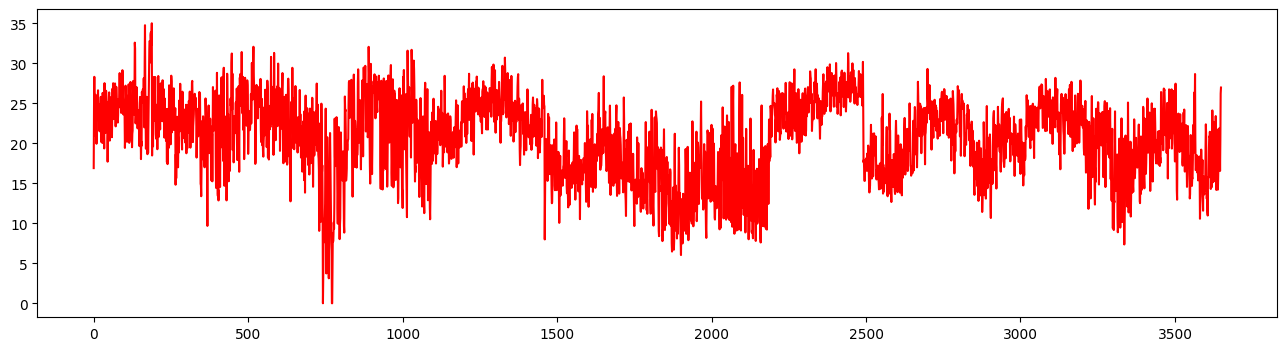

In [114]:
plt.figure(figsize=(16, 4))
plt.plot(np.array(reward_list), 'r')
# plt.ylim(0, 0.4)
plt.show() 

In [115]:
# data_test =  df[1][['GG', 'GC']]
# data_test['GC'].values[1]
# data_test.shape
data_test, df_date = utils.load_data([1], TS)
data_test = data_test[0]

(17520, 2)


In [116]:
capacity = 50.
env = utils.ENV_BATT(data_test, capacity)
state = env.reset()    
state = torch.tensor(state).unsqueeze(0)
    
# state = torch.tensor(np.array([data_test['GG'].values[0], data_test['GC'].values[0], 0., 0., capacity*BTMIN, 0., 0.0]), dtype=torch.float32).squeeze(0)
df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])
# state = state.clone().detach().unsqueeze(0)

with torch.no_grad():
    for i in range(env.data_env.shape[0]):
        action = select_action(state)
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state

/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_12783/460016207.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)


                      PV     LD   BT   AC     GD        RD
2012-07-01 00:30:00  0.0  1.710  5.0 -1.0  1.710  0.000000
2012-07-01 01:00:00  0.0  1.572  5.0 -1.0  1.572  0.000000
2012-07-01 01:30:00  0.0  1.208  5.0 -1.0  1.208  0.000000
2012-07-01 02:00:00  0.0  1.088  5.0 -1.0  1.088  0.000000
2012-07-01 02:30:00  0.0  1.194  5.0 -1.0  1.194  0.000000
...                  ...    ...  ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.828  5.0 -1.0  0.828  0.555131
2012-07-05 23:00:00  0.0  1.864  5.0 -1.0  1.864  0.556451
2012-07-05 23:30:00  0.0  0.140  5.0 -1.0  0.140  0.557130
2012-07-06 00:00:00  0.0  0.188  5.0 -1.0  0.188  0.557734
2012-07-06 00:30:00  0.0  0.112  5.0 -1.0  0.112  0.559176

[241 rows x 6 columns]


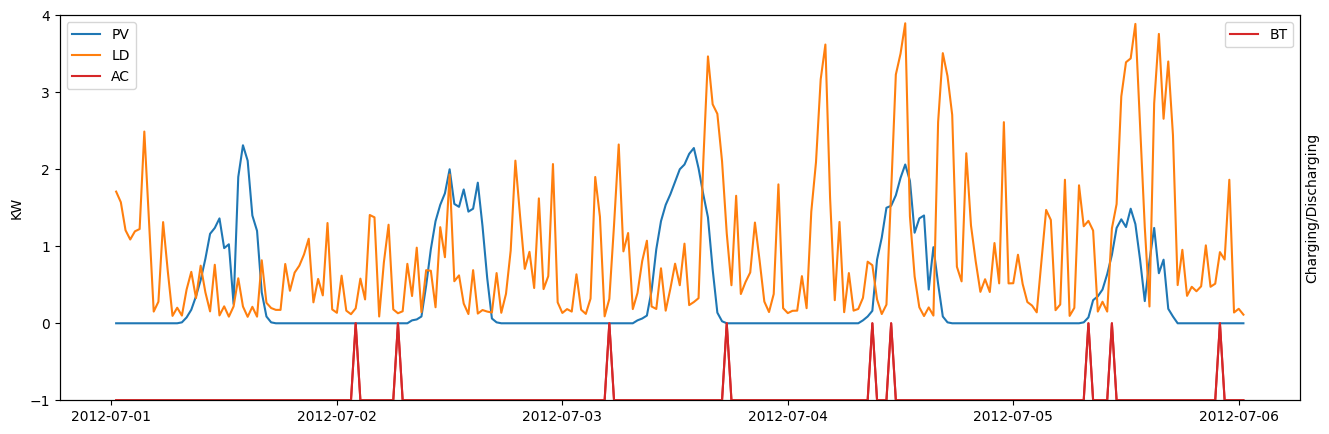

In [117]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

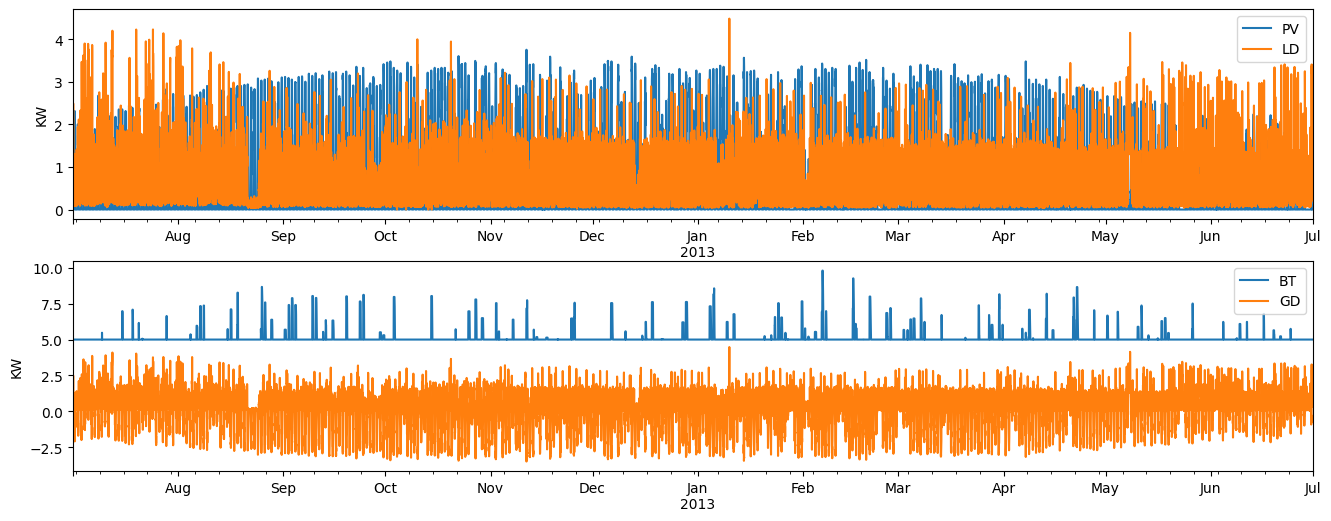

In [118]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [119]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

10230.414012374356 KW
10559.768004506826 KW
7857.138001992367
-7527.784000331303
SC : 0.2641760156308479
SS : 0.2559364950905732


In [120]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
# rd =  df_out['RD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    # ax1.plot(df_date.values, rd, label='RD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>